conda config --add channels conda-forge 

conda create -c conda-forge --override-channels --name geo osmnx
source activate geo

In [120]:
import osmnx as ox, geopandas as gpd, networkx as nx
import pandas as pd, numpy as np
import matplotlib.cm as cm
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

In [ ]:
# G2 = ox.graph_from_place('Lebanon, New Hampshire, USA', network_type='drive')
# G2 = ox.project_graph(G2)
# fig, ax = ox.plot_graph(G2)

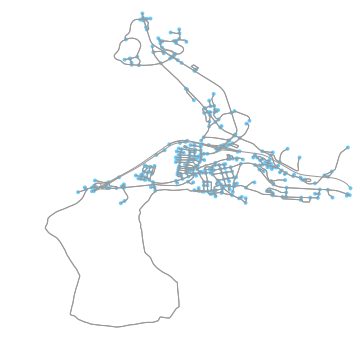

In [253]:
# G3, origin_point = ox.graph_from_address('42 Wolf Rd, Lebanon, New Hampshire', distance=3000, network_type='drive', return_coords=True)
# center_node = ox.get_nearest_node(G3, origin_point)
# G3 = ox.project_graph(G3)
# fig, ax = ox.plot_graph(G3)

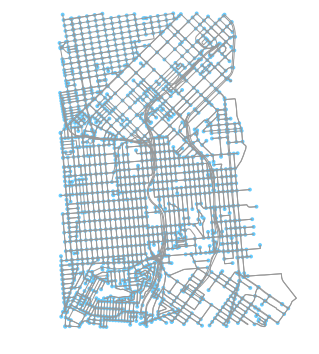

In [304]:
G3, origin_point = ox.graph_from_address('601 Minnesota Street, San Francisco, California', distance=3000, network_type='drive', return_coords=True)
center_node = ox.get_nearest_node(G3, origin_point)
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

In [305]:

# # define a bounding box in San Francisco
# north, south, east, west = 37.79, 37.78, -122.41, -122.43

# # create network from that bounding box
# G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive')#'drive_service')
# G1 = ox.project_graph(G1)
# fig, ax = ox.plot_graph(G1)

In [306]:
# RERUN FROM HERE to not hammer API
G = G3.copy()
# gdf_nodes = ox.graph_to_gdfs(G0, edges=False)
# x, y = gdf_nodes['geometry'].unary_union.centroid.xy
# center_node = ox.get_nearest_node(G0, (y[0], x[0]))
# center_node
# G = ox.project_graph(G0).copy()
# G = G0.copy()
# fig, ax = ox.plot_graph(G)

In [307]:
# defautl speeds from http://wiki.openstreetmap.org/wiki/OSM_tags_for_routing/Maxspeed

# 1 mph = 26.882 meters/minute
mph_to_minutes_per_meter = 26.882

def get_speed_meters_per_minute(edge_data):
    try:
        return float(data['maxspeed'].replace(' mph','')) * mph_to_minutes_per_meter
    except Exception as e:
        pass

    if edge_data['highway'] in ['motorway', 'trunk']:
        mph = 65
    elif edge_data['highway'] in ['motorway_link', 'trunk_link']:
        mph = 40
    elif edge_data['highway'] in ['primary_link']:
        mph = 25
    elif edge_data['highway'] in ['primary']:
        mph = 50
    elif edge_data['highway'] in ['secondary']:
        mph = 40
    elif edge_data['highway'] in ['tertiary']:
        mph = 30
    elif edge_data['highway'] in ['residential']:
        mph = 20
    elif edge_data['highway'] in ['service']:
        mph = 15
    elif 'link' in edge_data['highway']:
        mph = 20
    else:
        mph = 25
    return mph_to_minutes_per_meter

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['mpm'] = get_speed_meters_per_minute(data)
    data['time'] = data['length'] / data['mpm']
    data['through_traffic'] = 1

for n, data in G.nodes(data=True):
    data['source_traffic'] = 1

In [308]:

# pd.DataFrame([data for u, v, k, data in G.edges(data=True, keys=True)])
# pd.DataFrame([data for n, data in G.nodes(data=True)])
# G.nodes()[0]

In [309]:
# For every node in the map...
for origin_node in G.nodes():
    try:
        route = nx.shortest_path(G, origin_node, center_node, weight='time')
    except nx.NetworkXNoPath as e:
        continue

    # for that route, for every edge on the route, increment the through-traffic 
    #  count by the source traffic coming from the origin node..
    for i0, i1 in zip(route[:-1], route[1:]):
        G.edge[i0][i1][0]['through_traffic'] += G.node[origin_node]['source_traffic']
idx = np.log10(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
edge_widths = (idx / idx.max() ) * 3 + 1
idx = (idx / idx.max() ) * .95 + .05
idx = (idx*255).astype(np.uint8)

In [310]:
# cmap = cm.get_cmap(name='cubehelix').reversed()
# edge_colors = cmap(idx)
# fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths)

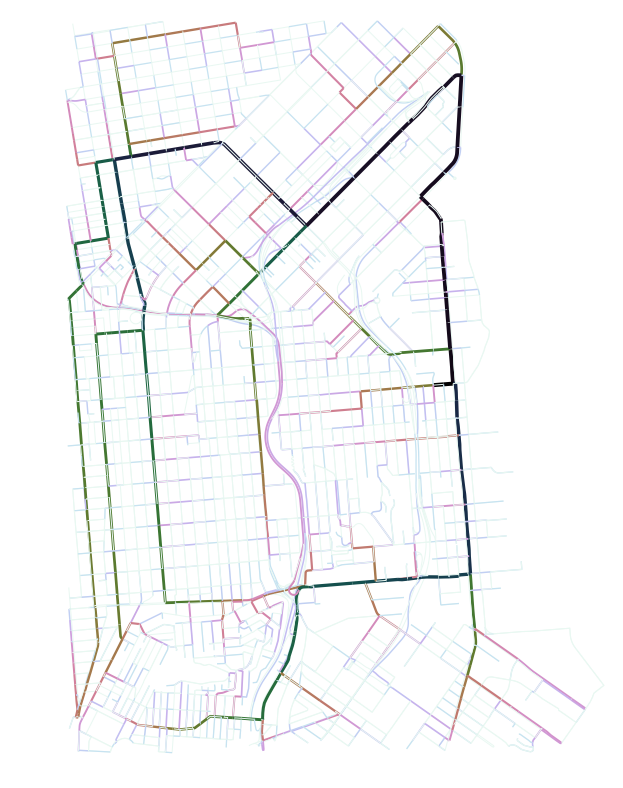

In [311]:
cmap = cm.get_cmap(name='cubehelix').reversed()
edge_colors = cmap(idx)
fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0,
                       fig_height=14, fig_width=16, use_geom=True)

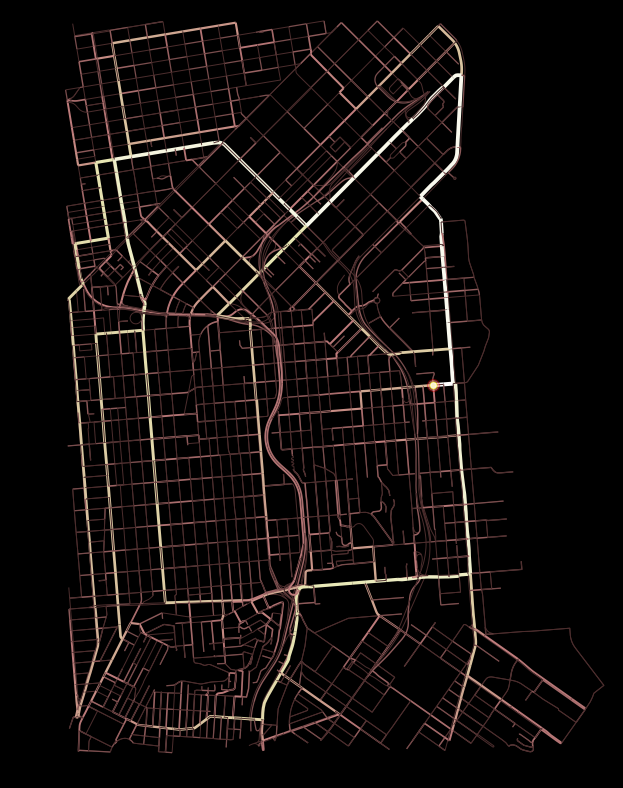

In [314]:
cmap = cm.get_cmap(name='pink')
edge_colors = cmap(idx)
# fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0,
#                        fig_height=14, fig_width=16, use_geom=True, bgcolor='k')
fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0,
                       fig_height=14, fig_width=16, use_geom=True , close=False, show=False,  bgcolor='k')
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='red', s=150, zorder=10, alpha=.25)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='pink', s=100, zorder=10, alpha=.3)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='yellow', s=50, zorder=10, alpha=.6)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='white', s=30, zorder=10, alpha=.75)
fig.show()

In [285]:
# fn = 'map.html'
# folium_map = ox.plot_graph_folium(G3, #edge_color=edge_colors.tolist(), 
#                               edge_width=2,#edge_widths.tolist(), 
# #                                  equal_aspect=True, node_size=0,
#  #                      fig_height=14, fig_width=16, use_geom=True
#                          )

In [286]:
# from IPython.display import IFrame
# folium_map.save(fn)
# IFrame(fn, width=600, height=500)